In [4]:
import pandas as pd

# Assuming the uploaded file is the one you want to read
file_path = '/Stocks_PnL_4285941043_01-04-2024_31-03-2025_report.xlsx'
df = pd.read_excel(file_path)

columns_to_ffill = ['Stock name', 'ISIN', 'Quantity', 'Buy date', 'Buy price', 'Buy value', 'Sell date', 'Sell price', 'Sell value', 'Realised P&L']
df[columns_to_ffill] = df[columns_to_ffill].fillna(method='ffill')
df['Remark'] = df['Remark'].fillna('No Remark')


df['Buy date'] = pd.to_datetime(df['Buy date'], errors='coerce', dayfirst=True)
df['Sell date'] = pd.to_datetime(df['Sell date'], errors='coerce', dayfirst=True)

numeric_cols = ['Quantity', 'Buy price', 'Buy value', 'Sell price', 'Sell value', 'Realised P&L']
for col in numeric_cols:
  df[col] = pd.to_numeric(df[col], errors='coerce')

/tmp/ipython-input-2978764918.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[columns_to_ffill] = df[columns_to_ffill].fillna(method='ffill')


In [5]:
import yfinance as yf

# Get a sample ISIN from the dataframe
sample_isin = df['ISIN'].iloc[0]
print(f"Sample ISIN: {sample_isin}")

# Attempt to find the ticker using yfinance
try:
    ticker = yf.Ticker(sample_isin)
    info = ticker.info
    if 'symbol' in info:
        print(f"Ticker for {sample_isin}: {info['symbol']}")
    else:
        print(f"Could not find ticker for {sample_isin}")
except Exception as e:
    print(f"An error occurred: {e}")
    print(f"Could not find ticker for {sample_isin}")

Sample ISIN: INE0GGX23010
An error occurred: Invalid ISIN number: INE0GGX23010
Could not find ticker for INE0GGX23010


In [6]:
import plotly.express as px
stock_pnl = df.groupby('Stock name')['Realised P&L'].sum().sort_values()

top_10_negative = stock_pnl.head(10)
top_10_positive = stock_pnl.tail(10)
extreme_pnl = pd.concat([top_10_negative, top_10_positive])



fig = px.bar(x=extreme_pnl.index, y=extreme_pnl.values,
             labels={'x': 'Stock Name', 'y': 'Total Realised P&L'},
             title='Top 10 Negative and Top 10 Positive Realised P&L Stocks (Plotly)',
             color=extreme_pnl.values,
             color_continuous_scale=['red', 'green'])
fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':extreme_pnl.index.tolist()},
                  template='plotly_dark')
fig.show()

In [7]:
import plotly.express as px

extreme_stocks_df = df[df['Stock name'].isin(extreme_pnl.index)]
pnl_by_trade_type = extreme_stocks_df.groupby(['Stock name', 'Remark'])['Realised P&L'].sum().reset_index()



fig = px.bar(pnl_by_trade_type,
             x='Stock name',
             y='Realised P&L',
             color='Remark',
             title='Realised P&L by Trade Type for Extreme Stocks',
             labels={'Realised P&L': 'Total Realised P&L'},
             barmode='group')


fig.update_layout(xaxis={'categoryorder':'total descending'},
                  template='plotly_dark')

fig.show()

In [8]:
selected_stocks = ['ANGEL ONE LIMITED', 'Polo Queen Industrial and Fint', 'RELIANCE INDUSTRIES LTD', 'BOROSIL RENEWABLES LTD']
selected_stocks_df = df[df['Stock name'].isin(selected_stocks)].copy()

stock_pnl_summary = df.groupby('Stock name')['Realised P&L'].agg(['count', lambda x: (x > 0).sum(), 'mean']).reset_index()
stock_pnl_summary.columns = ['Stock name', 'Total Trades', 'Profitable Trades', 'Average P&L']
stock_pnl_summary['Win Rate'] = stock_pnl_summary['Profitable Trades'] / stock_pnl_summary['Total Trades']

remark_pnl_summary = df.groupby('Remark')['Realised P&L'].agg(['count', lambda x: (x > 0).sum(), 'mean']).reset_index()
remark_pnl_summary.columns = ['Remark', 'Total Trades', 'Profitable Trades', 'Average P&L']
remark_pnl_summary['Win Rate'] = remark_pnl_summary['Profitable Trades'] / remark_pnl_summary['Total Trades']

## Holding period analysis
Calculate the holding period for each trade and visualize its distribution, potentially comparing profitable vs. unprofitable trades or different trade types

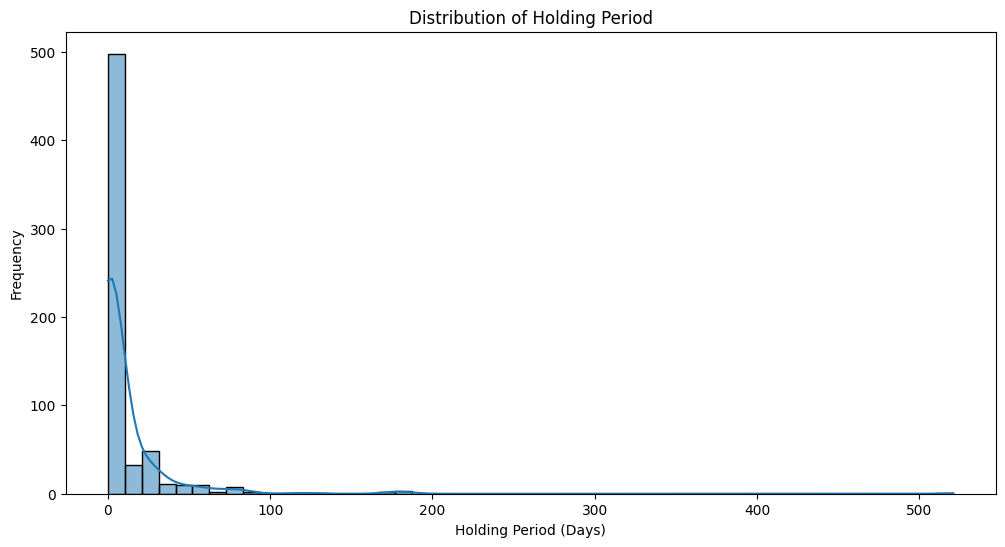

In [23]:
df['Holding Period'] = (df['Sell date'] - df['Buy date']).dt.days
df['Trade Outcome'] = df['Realised P&L'].apply(lambda x: 'Profitable' if x > 0 else 'Unprofitable')

plt.figure(figsize=(12, 6))
sns.histplot(df['Holding Period'], bins=50, kde=True)
plt.title('Distribution of Holding Period')
plt.xlabel('Holding Period (Days)')
plt.ylabel('Frequency')
plt.show()

## Transaction-level analysis visualization

Select a few interesting stocks (e.g., from the extreme P&L list) and visualize their individual buy and sell transactions over time, along with the resulting P&L


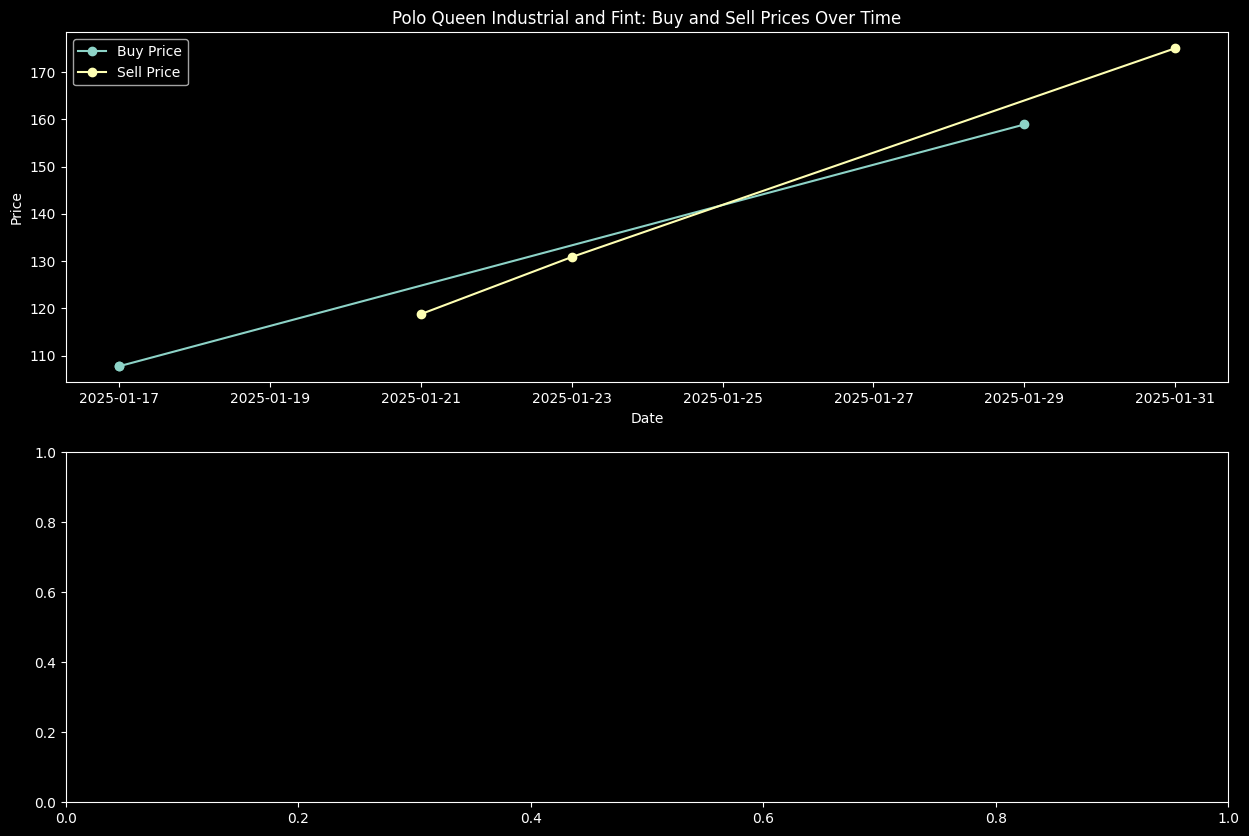

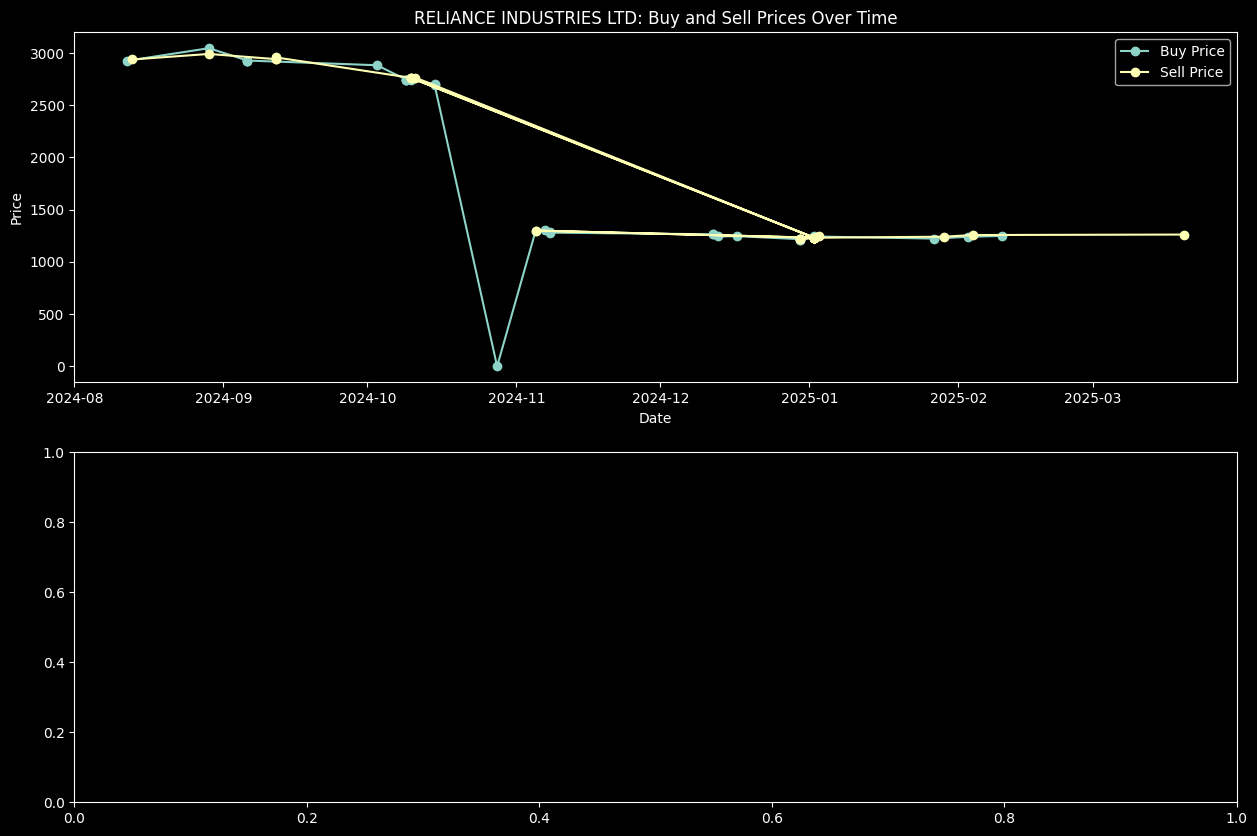

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_stocks = ['Polo Queen Industrial and Fint', 'RELIANCE INDUSTRIES LTD']

for stock in selected_stocks:
    stock_df = df[df['Stock name'] == stock].copy()

    plt.style.use('dark_background')
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # Price plot
    axes[0].plot(stock_df['Buy date'], stock_df['Buy price'], 'o-', label='Buy Price')
    axes[0].plot(stock_df['Sell date'], stock_df['Sell price'], 'o-', label='Sell Price')
    axes[0].set_title(f'{stock}: Buy and Sell Prices Over Time')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Price')
    axes[0].legend()
    #axes[0].grid(True)

    plt.show()

plt.style.use('default')

In [11]:
import plotly.express as px

stock_pnl_summary = df.groupby('Stock name')['Realised P&L'].agg(['count', lambda x: (x > 0).sum(), 'mean']).reset_index()
stock_pnl_summary.columns = ['Stock name', 'Total Trades', 'Profitable Trades', 'Average P&L']
stock_pnl_summary['Win Rate'] = stock_pnl_summary['Profitable Trades'] / stock_pnl_summary['Total Trades']


remark_pnl_summary = df.groupby('Remark')['Realised P&L'].agg(['count', lambda x: (x > 0).sum(), 'mean']).reset_index()
remark_pnl_summary.columns = ['Remark', 'Total Trades', 'Profitable Trades', 'Average P&L']
remark_pnl_summary['Win Rate'] = remark_pnl_summary['Profitable Trades'] / remark_pnl_summary['Total Trades']

fig1 = px.scatter(df, x='Quantity', y='Realised P&L', color='Buy price',
                 labels={'Quantity': 'Quantity', 'Realised P&L': 'Realised P&L', 'Buy price': 'Buy Price'},
                 title='Quantity vs. Realised P&L colored by Buy Price')
fig1.update_layout(template='plotly_dark')
fig1.show()

fig2 = px.scatter(df, x='Buy price', y='Realised P&L', size='Quantity',
                 labels={'Buy price': 'Buy Price', 'Realised P&L': 'Realised P&L', 'Quantity': 'Quantity'},
                 title='Buy Price vs. Realised P&L with marker size by Quantity')
fig2.update_layout(template='plotly_dark')
fig2.show()

/tmp/ipython-input-1979811287.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




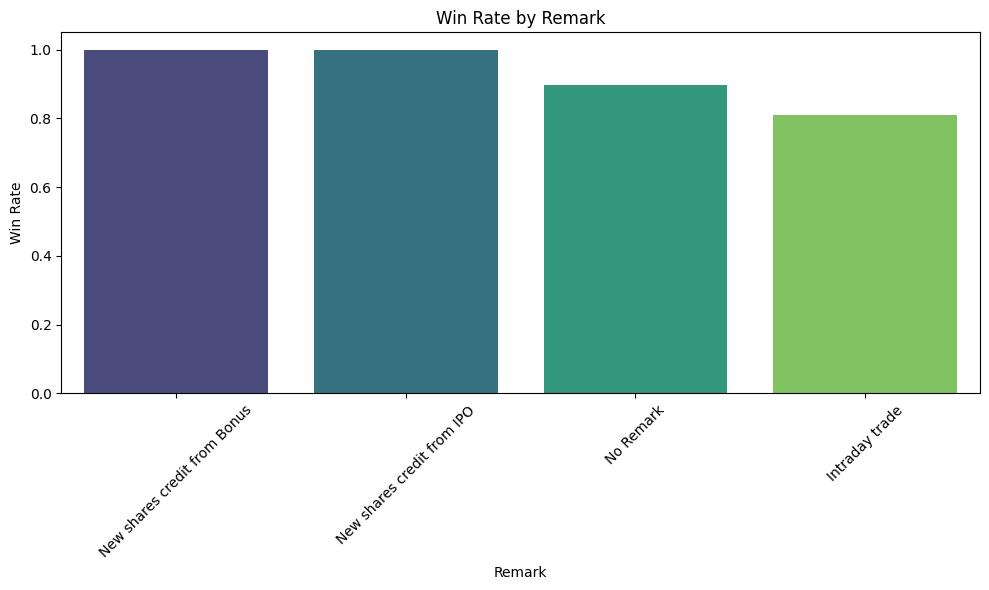

/tmp/ipython-input-1979811287.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




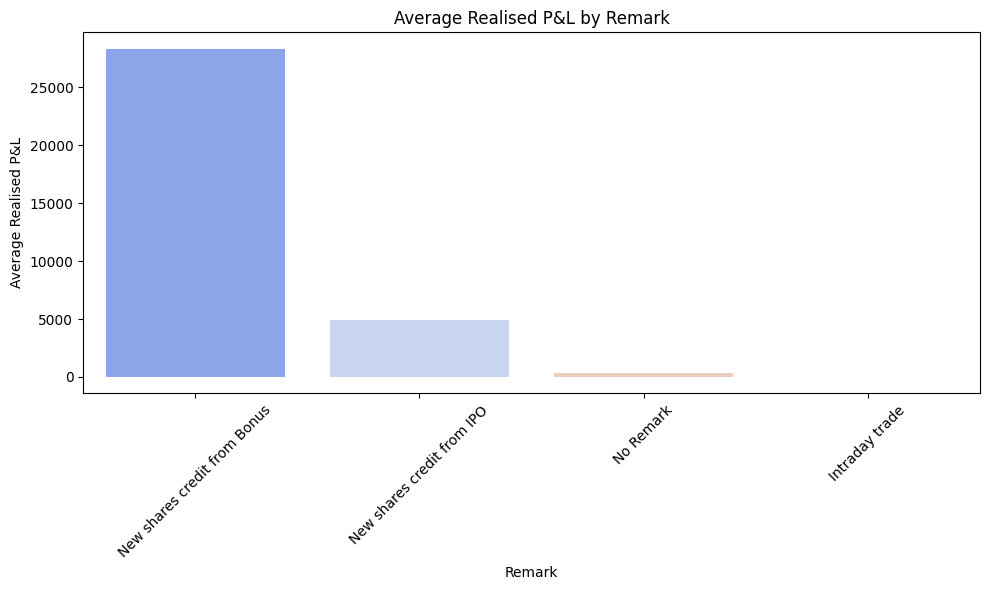

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Remark', y='Win Rate', data=remark_pnl_summary.sort_values('Win Rate', ascending=False), palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Remark')
plt.ylabel('Win Rate')
plt.title('Win Rate by Remark')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Remark', y='Average P&L', data=remark_pnl_summary.sort_values('Average P&L', ascending=False), palette='coolwarm')
plt.xticks(rotation=45)
plt.xlabel('Remark')
plt.ylabel('Average Realised P&L')
plt.title('Average Realised P&L by Remark')
plt.tight_layout()
plt.show()

## Price and quantity analysis visualization
Price and quantity analysis visualization


In [13]:
import plotly.express as px

# Scatter plot of Quantity vs. Realised P&L colored by Buy Price
fig1 = px.scatter(df, x='Quantity', y='Realised P&L', color='Buy price',
                 labels={'Quantity': 'Quantity', 'Realised P&L': 'Realised P&L', 'Buy price': 'Buy Price'},
                 title='Quantity vs. Realised P&L colored by Buy Price')
fig1.update_layout(template='plotly_dark')
fig1.show()

# Scatter plot of Buy Price vs. Realised P&L with marker size by Quantity
fig2 = px.scatter(df, x='Buy price', y='Realised P&L', size='Quantity',
                 labels={'Buy price': 'Buy Price', 'Realised P&L': 'Realised P&L', 'Quantity': 'Quantity'},
                 title='Buy Price vs. Realised P&L with marker size by Quantity')
fig2.update_layout(template='plotly_dark')
fig2.show()

## Time-based trends visualization
Analyze and visualize the realized P&L over time (e.g., monthly or quarterly)

In [17]:
import yfinance as yf
from datetime import datetime
import pandas as pd

nifty_ticker = '^NSEI'
start_date = '2024-04-01'
end_date = '2025-03-31'

nifty_data = yf.download(nifty_ticker, start=start_date, end=end_date)

monthly_nifty_close = nifty_data['Close'].resample('ME').last()
monthly_nifty_change = monthly_nifty_close.pct_change().dropna()

monthly_pnl = df.set_index('Sell date')['Realised P&L'].resample('ME').sum()

monthly_pnl_df = monthly_pnl.reset_index()
monthly_pnl_df.columns = ['Date', 'Realised P&L']

monthly_nifty_change_df = monthly_nifty_change.reset_index()
monthly_nifty_change_df.columns = ['Date', 'Nifty Change']

combined_monthly_data = pd.merge(monthly_pnl_df, monthly_nifty_change_df, on='Date', how='inner')
combined_monthly_data['Realised P&L Change'] = combined_monthly_data['Realised P&L'].pct_change().fillna(0)


import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=combined_monthly_data['Date'], y=combined_monthly_data['Nifty Change'],
                         mode='lines',
                         name='Nifty Change'))

fig.add_trace(go.Scatter(x=combined_monthly_data['Date'], y=combined_monthly_data['Realised P&L Change'],
                         mode='lines',
                         name='Realised P&L Change'))

fig.update_layout(title='Monthly Nifty Change vs. Monthly Realised P&L Change',
                  xaxis_title='Date',
                  yaxis_title='Percentage Change',
                  template='plotly_dark')

fig.show()

/tmp/ipython-input-1651519792.py:9: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


# Task
Create a Plotly line chart comparing the cumulative invested amount, realized P&L, and Nifty trend over time, using a dark background and appropriate coloring.

In [18]:
df_sorted = df.sort_values('Buy date')
df_sorted['Invested Amount'] = df_sorted['Quantity'] * df_sorted['Buy price']
df_sorted['Cumulative Invested Amount'] = df_sorted['Invested Amount'].cumsum()

**Reasoning**:
Resample the Realised P&L to a monthly frequency and sum the P&L for each month.



In [19]:
monthly_pnl = df.set_index('Sell date')['Realised P&L'].resample('ME').sum()

## Combine data

### Subtask:
Merge or combine the cumulative invested amount, realized P&L, and Nifty data into a single DataFrame.


**Reasoning**:
Convert the index of `monthly_pnl` to datetime, resample `df_sorted` by month and take the last cumulative invested amount, and then merge with `combined_monthly_data`.



In [20]:
monthly_pnl.index = pd.to_datetime(monthly_pnl.index)
monthly_cumulative_invested = df_sorted.set_index('Buy date')['Cumulative Invested Amount'].resample('ME').last().ffill()
combined_monthly_data = pd.merge(combined_monthly_data, monthly_cumulative_invested.rename('Cumulative Invested Amount'), left_on='Date', right_index=True, how='left')
combined_monthly_data = combined_monthly_data.ffill()
display(combined_monthly_data)

,Date,Realised P&L,Nifty Change,Realised P&L Change,Cumulative Invested Amount
0,2024-05-31,631.10,-0.003280,0.000000,701846.55
1,2024-06-30,599.78,0.065684,-0.049628,1129557.69
2,2024-07-31,3863.33,0.039172,5.441245,1474353.86
3,2024-08-31,18699.20,0.011412,3.840177,6343594.24
4,2024-09-30,18640.02,0.022783,-0.003165,11098651.51
5,2024-10-31,12035.26,-0.062203,-0.354332,21673224.06
6,2024-11-30,1832.58,-0.003068,-0.847732,25128259.05
7,2024-12-31,40365.89,-0.020152,21.026809,33104839.63
8,2025-01-31,35435.11,-0.005769,-0.122152,36459009.31
9,2025-02-28,9206.84,-0.058860,-0.740177,41458240.99


## Normalize or scale data

### Subtask:
Normalize or scale the 'Cumulative Invested Amount', 'Realised P&L', and 'Nifty Change' columns in the `combined_monthly_data` DataFrame so they can be meaningfully compared on the same plot.


**Reasoning**:
Normalize the data using MinMaxScaler to prepare for plotting on the same scale.



In [21]:
from sklearn.preprocessing import MinMaxScaler

scaled_data = combined_monthly_data[['Cumulative Invested Amount', 'Realised P&L', 'Nifty Change']]

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(scaled_data)

combined_monthly_data['Scaled Invested Amount'] = scaled_values[:, 0]
combined_monthly_data['Scaled Realised P&L'] = scaled_values[:, 1]
combined_monthly_data['Scaled Nifty Change'] = scaled_values[:, 2]

In [22]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=combined_monthly_data['Date'], y=combined_monthly_data['Scaled Invested Amount'],
                         mode='lines',
                         name='Cumulative Invested Amount'))

fig.add_trace(go.Scatter(x=combined_monthly_data['Date'], y=combined_monthly_data['Scaled Realised P&L'],
                         mode='lines',
                         name='Realised P&L'))

fig.add_trace(go.Scatter(x=combined_monthly_data['Date'], y=combined_monthly_data['Scaled Nifty Change'],
                         mode='lines',
                         name='Nifty Change'))

fig.update_layout(title='Comparison of Scaled Cumulative Invested Amount, Realised P&L, and Nifty Change Over Time',
                  xaxis_title='Date',
                  yaxis_title='Scaled Value',
                  template='plotly_dark')

fig.show()